In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2, os, seaborn

In [ ]:
resnet = tf.keras.applications.ResNet50()

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
resnet.input_shape

(None, 224, 224, 3)

In [ ]:
resnet.output_shape

(None, 1000)

In [ ]:
! wget https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg

--2023-11-26 14:46:49--  https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229955 (225K) [image/jpeg]
Saving to: ‘dog-puppy-on-garden-royalty-free-image-1586966191.jpg’

dog-puppy-on-garden 100%[===================>] 224.57K  --.-KB/s    in 0.02s   

2023-11-26 14:46:49 (10.6 MB/s) - ‘dog-puppy-on-garden-royalty-free-image-1586966191.jpg’ saved [229955/229955]



In [ ]:
image = cv2.imread("dog-puppy-on-garden-royalty-free-image-1586966191.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = np.expand_dims(image, axis=0)
image.shape

(1, 224, 224, 3)

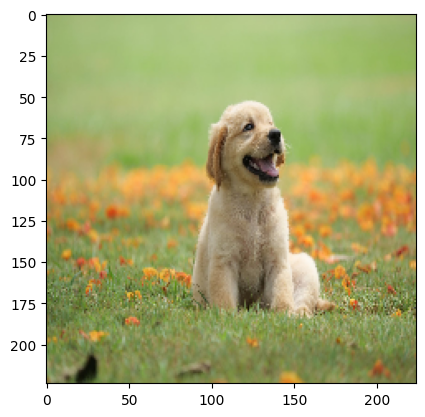

In [ ]:
plt.imshow(image[0])

In [ ]:
# Preprocessing
image = tf.keras.applications.resnet50.preprocess_input(image)

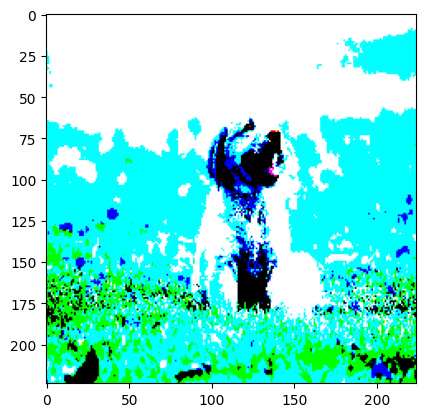

In [ ]:
plt.imshow(image[0])

In [ ]:
result = resnet.predict(image)

1/1 [==============================] - 3s 3s/step


In [ ]:
tf.keras.applications.resnet50.decode_predictions(result)

35363/35363 [==============================] - 0s 0us/step


[[('n02113799', 'standard_poodle', 0.7261912),
  ('n02099601', 'golden_retriever', 0.18983835),
  ('n02099712', 'Labrador_retriever', 0.054810375),
  ('n02113712', 'miniature_poodle', 0.011798887),
  ('n02102318', 'cocker_spaniel', 0.004343479)]]

In [ ]:
# applications = https://keras.io/api/applications/

In [ ]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

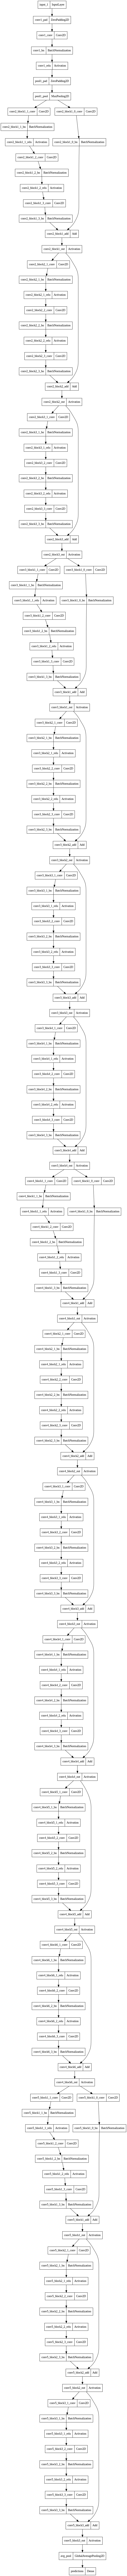

In [ ]:
tf.keras.utils.plot_model(resnet)

In [ ]:
resnet.to_json()

'{"class_name": "Functional", "config": {"name": "resnet50", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": true, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, 224, 224, 3]}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initi

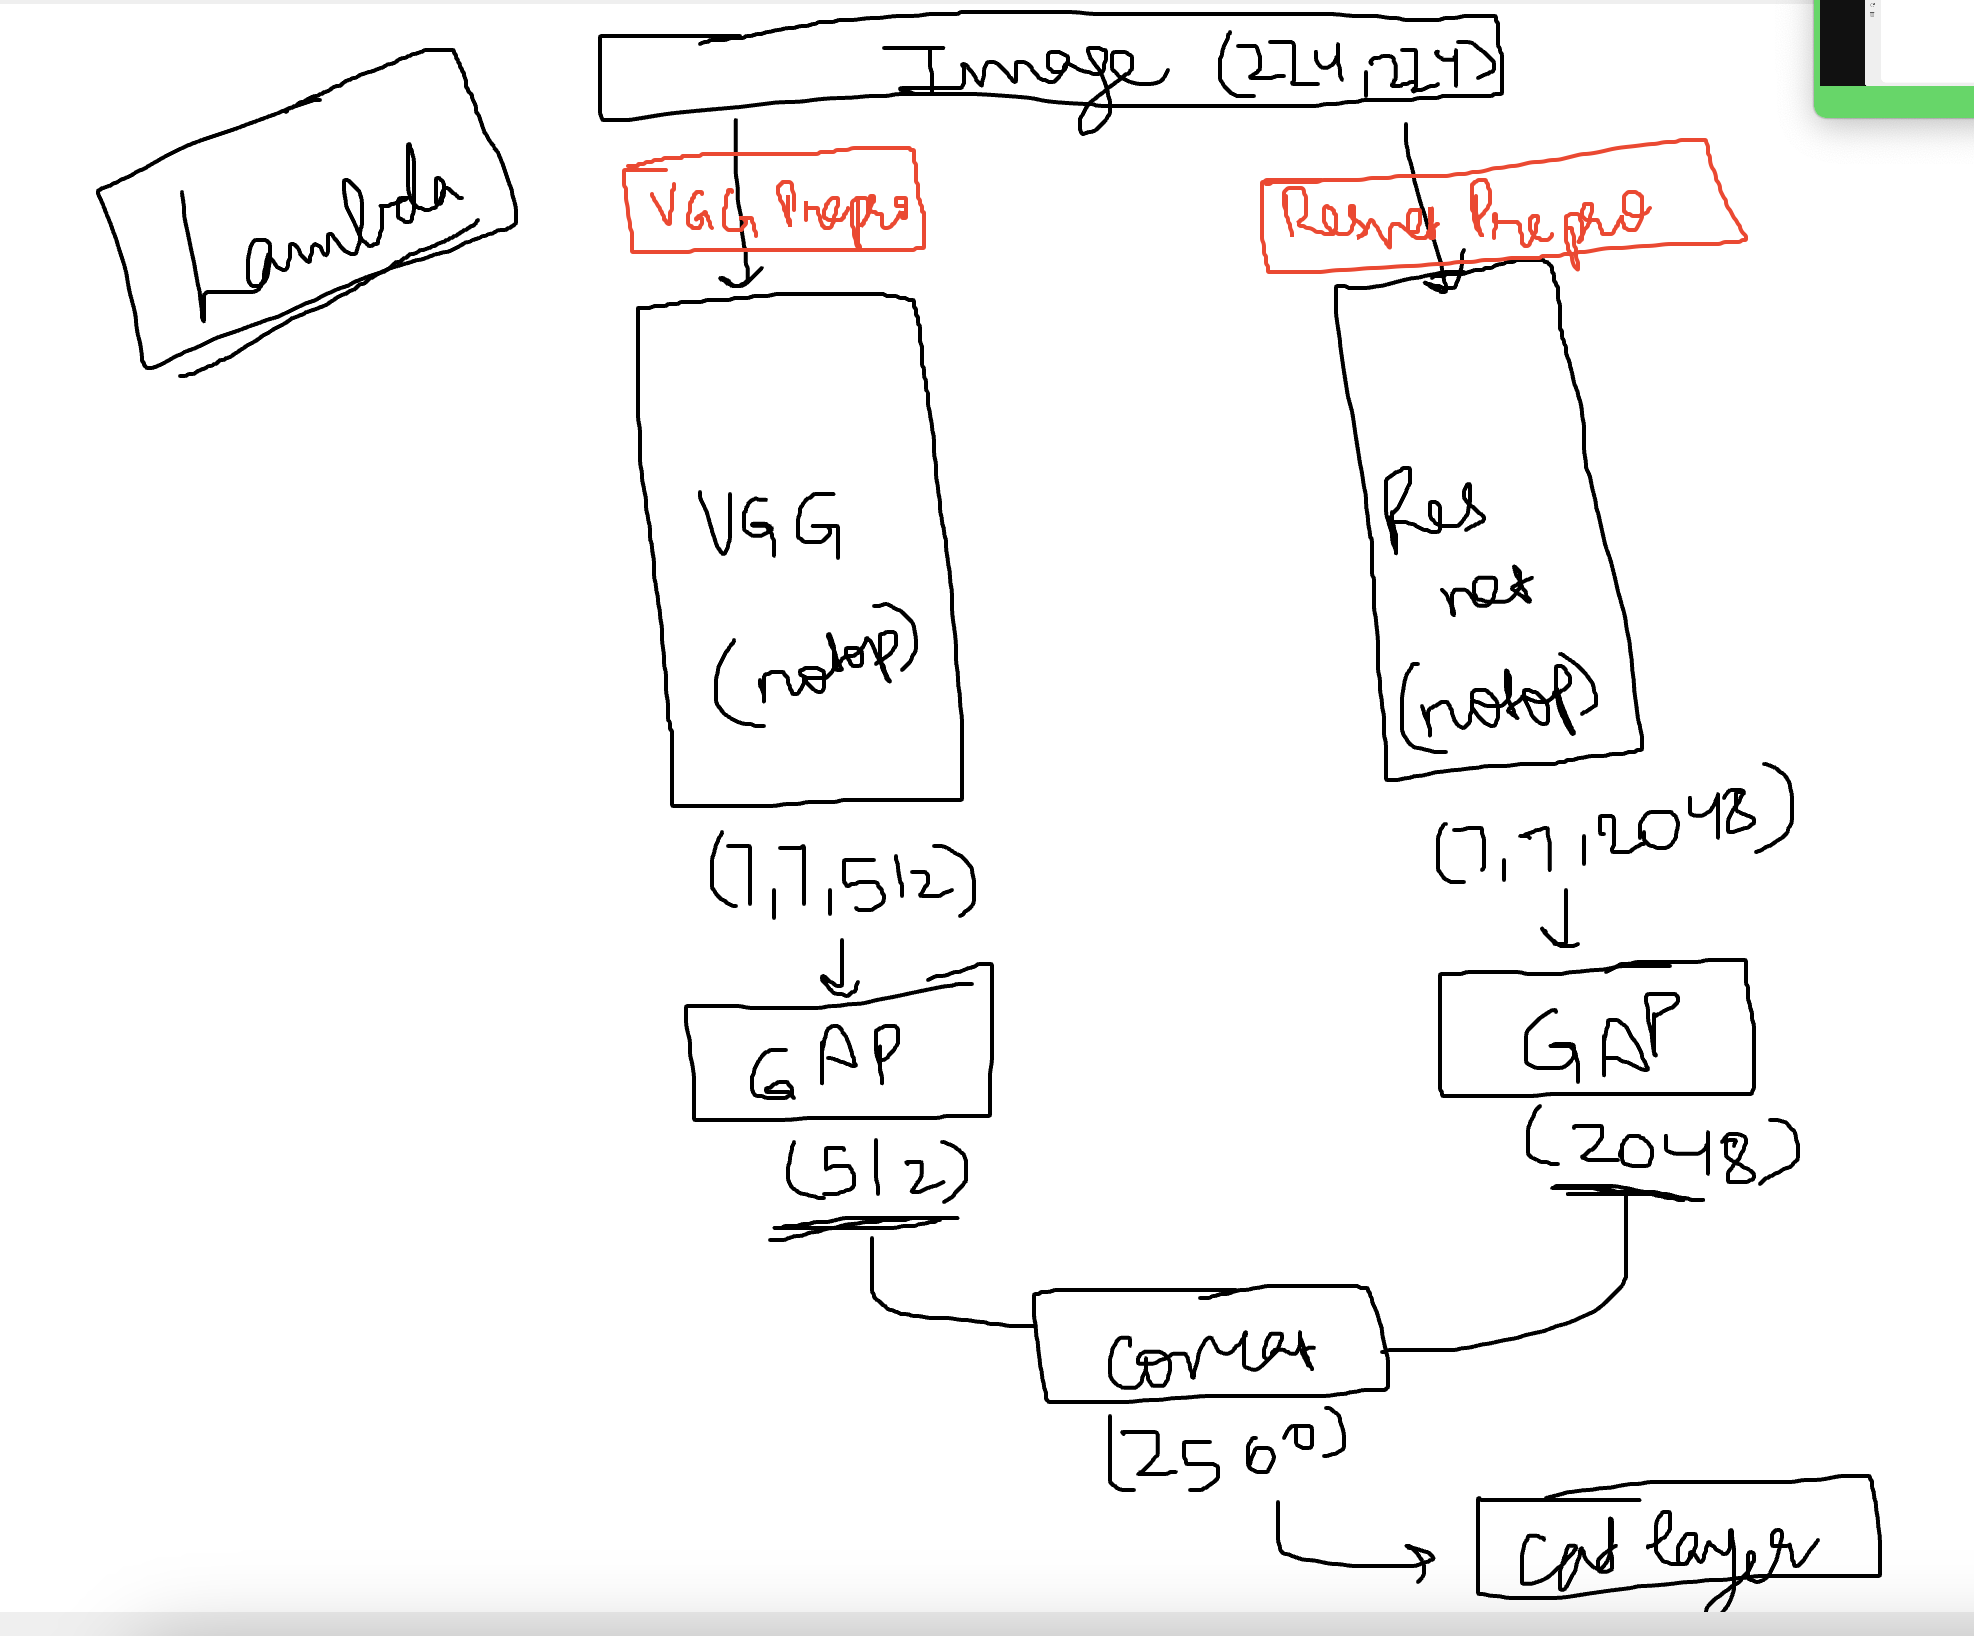

In [ ]:
#Download data -
! mkdir -p /root/.kaggle
! mv kaggle.json /root/.kaggle
import kaggle
! kaggle competitions download -c dog-breed-identification
! unzip -q dog-breed-identification.zip

 98% 677M/691M [00:03<00:00, 201MB/s]
100% 691M/691M [00:03<00:00, 215MB/s]


In [ ]:
label = pd.read_csv("labels.csv")
label.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
label["id"] = label["id"] + ".jpg"

In [ ]:
# Image Data Generator
batch_size = 64
idg = tf.keras.preprocessing.image.ImageDataGenerator(
                                                      validation_split=0.1,
                                                      rotation_range=30,
                                                      horizontal_flip=True)

train_idg = idg.flow_from_dataframe(label, "train/", "id", "breed",
                                    target_size=(224, 224),
                                    batch_size = batch_size,
                                    subset="training")
val_idg = idg.flow_from_dataframe(label, "train/", "id", "breed",
                                    target_size=(224, 224),
                                    batch_size = batch_size,
                                    subset="validation")

Found 9200 validated image filenames belonging to 120 classes.
Found 1022 validated image filenames belonging to 120 classes.


In [ ]:
# Model -

#Input -
input = tf.keras.layers.Input((224, 224, 3), name='inputlayer')

################################################################
#### VGG

# Preprocessing in layers -
vgg_pre_pro = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name="vggPrepro") (input)

#download the vgg no_top model
vgg_notop = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))
vgg_notop.trainable = False

# Model as a layer
vgg = vgg_notop (vgg_pre_pro)

# Global Avg Pooling
vgg_gap = tf.keras.layers.GlobalAveragePooling2D(name="vggGap") (vgg)

################################################################
### Resnet
# Resnet Preprocessing -
resnet_pre_pro = tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, name='resnetPrepro') (input)

# download resent model
resnet_notop = tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3))
resnet_notop.trainable = False

# model as a layer
resnet = resnet_notop (resnet_pre_pro)

# global avg pooling
resnet_gap = tf.keras.layers.GlobalAveragePooling2D(name="resnetGap") (resnet)
################################################################

# Concat
concat = tf.keras.layers.Concatenate(name="concat") ([vgg_gap, resnet_gap])
# dropout = tf.keras.layers.Dropout(0.50) (concat)
dense = tf.keras.layers.Dense(256, activation='relu', name='dense') (concat)
output = tf.keras.layers.Dense(120, activation='softmax', name='output') (dense)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
final_model = tf.keras.models.Model(inputs= [input], outputs= [output])

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputlayer (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vggPrepro (Lambda)          (None, 224, 224, 3)          0         ['inputlayer[0][0]']          
                                                                                                  
 resnetPrepro (Lambda)       (None, 224, 224, 3)          0         ['inputlayer[0][0]']          
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['vggPrepro[0][0]']           
                                                          8                                   

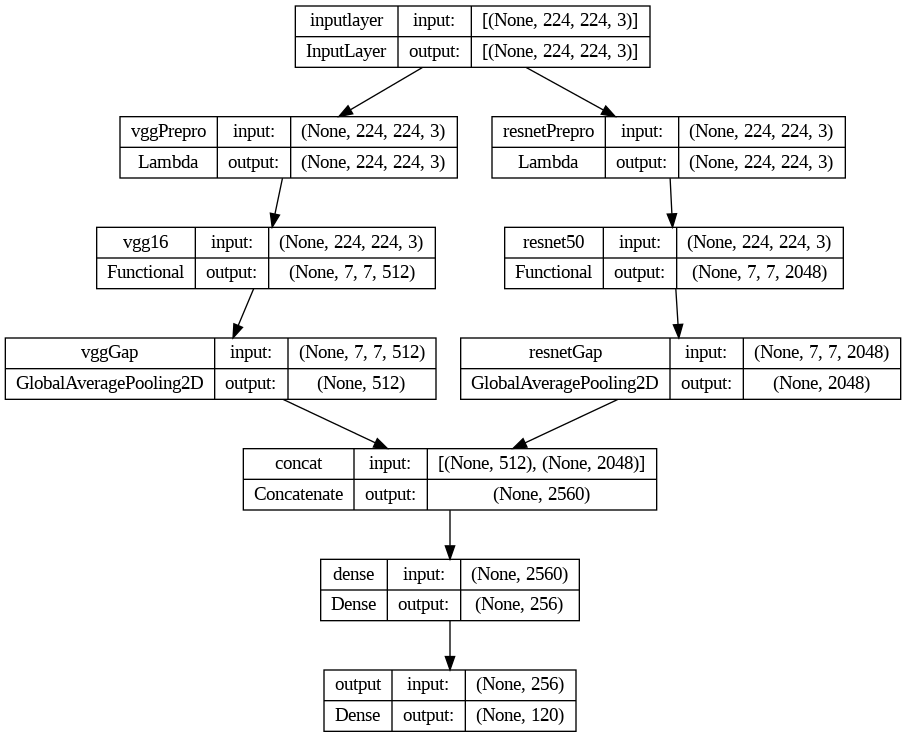

In [ ]:
tf.keras.utils.plot_model(final_model, show_layer_names=True, show_shapes=True)

In [ ]:
final_model.compile(tf.keras.optimizers.SGD(), tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [ ]:
final_model.fit(train_idg, batch_size = batch_size, epochs=10, validation_data = val_idg)

Epoch 1/10
144/144 [==============================] - 197s 1s/step - loss: 3.4774 - acc: 0.2354 - val_loss: 2.3334 - val_acc: 0.4070
Epoch 2/10
144/144 [==============================] - 162s 1s/step - loss: 1.7901 - acc: 0.5192 - val_loss: 1.8046 - val_acc: 0.5245
Epoch 3/10
144/144 [==============================] - 158s 1s/step - loss: 1.3467 - acc: 0.6193 - val_loss: 1.5828 - val_acc: 0.5783
Epoch 4/10
144/144 [==============================] - 161s 1s/step - loss: 1.1180 - acc: 0.6783 - val_loss: 1.4383 - val_acc: 0.6194
Epoch 5/10
144/144 [==============================] - 159s 1s/step - loss: 0.9701 - acc: 0.7151 - val_loss: 1.3587 - val_acc: 0.6350
Epoch 6/10
144/144 [==============================] - 167s 1s/step - loss: 0.8554 - acc: 0.7466 - val_loss: 1.3606 - val_acc: 0.6125
Epoch 7/10
 44/144 [========>.....................] - ETA: 1:40 - loss: 0.7511 - acc: 0.7738

KeyboardInterrupt: ignored

In [ ]:
# vgg, resnet, inception, efficientnet

In [ ]:
final_model.save("dog-breed-model") # save the model

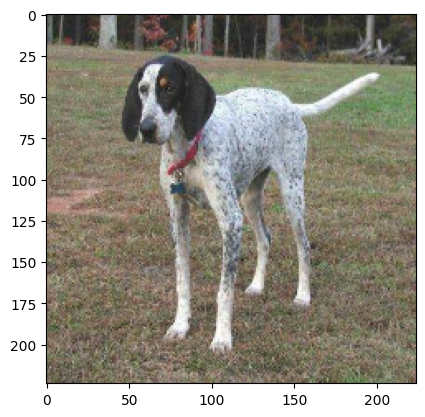

In [ ]:
# prediction
testimage = cv2.imread("train/00214f311d5d2247d5dfe4fe24b2303d.jpg")
testimage = cv2.resize(testimage, (224, 224))
testimage = cv2.cvtColor(testimage, cv2.COLOR_BGR2RGB)
testimage = np.expand_dims(testimage, axis=0)
plt.imshow(testimage[0])

In [ ]:
result = final_model.predict(testimage)

1/1 [==============================] - 4s 4s/step


In [ ]:
np.max(result)

0.9087445

In [ ]:
np.argmax(result) # bluetick

15

In [ ]:
label.loc[label["id"] == "00214f311d5d2247d5dfe4fe24b2303d.jpg"]

,id,breed
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick


In [ ]:
train_idg.class_indices

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [ ]:
# model1 --> final_model1 (vgg + resnet)

# model2 --> final_model2